In [2]:
import pandas as pd
import seaborn as sns
# import pyspark
# spark = pyspark.sql.SparkSession.builder.appName('Test').getOrCreate()

### Read data

In [3]:
parquet = "G:/My Drive/data/grab-posis/city=Singapore/part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet"
df = pd.read_parquet(parquet)
df
# df = spark.read.parquet(parquet)
# df.columns

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
0,70014,car,android,1554943236,1.342326,103.888969,18.910000,248,3.9
1,73573,car,android,1555582623,1.321781,103.856366,17.719076,44,4.0
2,75567,car,android,1555141026,1.327088,103.861273,14.021548,34,3.9
3,1410,car,android,1555731693,1.262482,103.823794,13.026521,181,4.0
4,4354,car,android,1555584497,1.283799,103.807210,14.812943,93,3.9
...,...,...,...,...,...,...,...,...,...
3034548,67126,car,android,1554971237,1.349722,103.792840,18.255438,93,6.0
3034549,11786,car,android,1555248352,1.386651,103.774858,23.341484,352,6.0
3034550,21686,car,ios,1555805714,1.329604,103.822454,23.468313,111,5.0
3034551,70139,car,android,1555685891,1.322202,103.886999,20.248346,266,6.0


In [4]:
pop_data = "G:/My Drive/data/grab-posis/population-density/population_sgp_2018-10-01.csv"
pop_df = pd.read_csv(pop_data)
pop_df
# pop_df = spark.read.option("header", "true").csv(pop_data)
# pop_df.show()

,latitude,longitude,population_2015,population_2020
0,1.175139,103.733750,0.000000,0.000000
1,1.175417,103.733472,0.000000,0.000000
2,1.182361,103.721250,0.000000,0.000000
3,1.183750,103.721806,0.000000,0.000000
4,1.184028,103.721528,0.000000,0.000000
...,...,...,...,...
142555,1.470694,103.817083,37.020323,54.434904
142556,1.470694,103.817361,37.020323,54.434904
142557,1.470972,103.818194,37.020323,54.434904
142558,1.470972,103.827917,37.020323,54.434904


In [5]:
# window = pyspark.sql.Window().partitionBy("")
# lats = pop_df['latitude'].collect().sorted

In [5]:
from scipy.interpolate import griddata
import numpy as np

CHUNKS = 1000
ICHUNKS = 1000j

minlng, maxlng = df['rawlng'].min(), df['rawlng'].max()
minlat, maxlat = df['rawlat'].min(), df['rawlat'].max()
print('lats limits', minlng, maxlng)
print('lngs limits', minlat, maxlat)
grid_x, grid_y = np.mgrid[minlng:maxlng:ICHUNKS, minlat:maxlat:ICHUNKS]
grid = griddata(pop_df[['longitude', 'latitude']], pop_df[['population_2020']], (grid_x, grid_y), method='linear')
# np.savetxt('grid.csv', grid.squeeze())

lats limits 103.6144247 104.03137003081235
lngs limits 1.2415846885343818 1.4656086


In [6]:
from scipy.interpolate import interp2d, RectBivariateSpline, RegularGridInterpolator
x_idx = np.linspace(minlng, maxlng, num=CHUNKS)
y_idx = np.linspace(minlat, maxlat, num=CHUNKS)
f = RegularGridInterpolator((x_idx, y_idx), grid, method='linear')
# f = RectBivariateSpline(x_idx, y_idx, grid)
# f = interp2d(grid_x, grid_y, grid)
# f = interp2d(pop_df['longitude'], pop_df['latitude'], pop_df['population_2020'])
len(grid_x), len(grid_y), grid.shape

(1000, 1000, (1000, 1000, 1))

(latitude             1.285694
 longitude          103.827361
 population_2015     48.339490
 population_2020     48.085619
 Name: 10230, dtype: float64,
 array([48.08561892]))

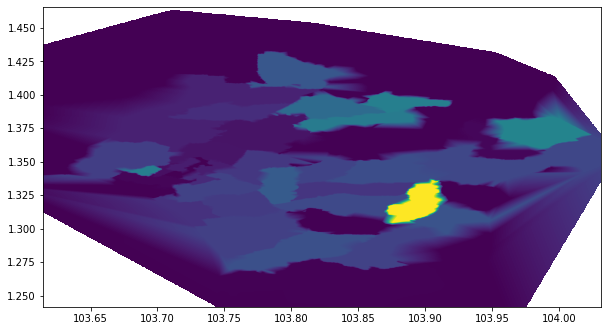

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(grid, extent=(minlng,maxlng,minlat,maxlat))
plt.savefig('heatmap.png')
np.savetxt('inference.csv', f(np.stack((x_idx, y_idx), axis=1)))

### Generate new geofeature

In [27]:
def find_closest_location(x, feature: pd.DataFrame, name: str):
    latdist = (feature['latitude'] - x[0]).abs()
    lngdist = (feature['longitude'] - x[1]).abs()
    idx = (latdist + lngdist).argsort()[0]
    return feature.loc[idx, name]

def interpolate_feature(x, f):
    return f((x[1], x[0]))

# df[['rawlat', 'rawlng']][:10].apply(find_closest_location, args=(pop_df, "population_2020",), axis=1)
pop2020 = df[['rawlat', 'rawlng']].apply(interpolate_feature, args=(f,), axis=1)

0       [56.847899909914155]
1        [45.13951754451628]
2        [44.26053573574047]
3        [48.08561892022989]
4        [48.08561892022989]
                ...         
9995     [50.60761731918489]
9996    [61.291141300769524]
9997     [48.60301295029036]
9998    [14.057298943134537]
9999     [48.22184089837168]
Length: 10000, dtype: object